In [55]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [56]:
# DEFAULT PARAMETERS USED FOR FINETUNING
# DO NOT CHANGE
BUFFER_SIZE_SECONDS = 5
PREDICTION_INTERVAL = 0.15
WARMUP_TIME = max(2.0, BUFFER_SIZE_SECONDS + 0.2)
CONFIDENCE_THRESHOLD = 0.95
ALPHA = 0.8
TIMEOUT = 0.8
NUM_FRAMES = 8
TEMPERATURE = 1

In [62]:
VIDEO_1_THRESHOLD = ([0, 44], "pause")
VIDEO_2_THRESHOLD = ([10, 21.5], "front russian-twist") # Front 
VIDEO_3_THRESHOLD = ([10, 22], "side russian-twist") # Side
VIDEO_4_THRESHOLD = ([10, 20.5], "front squat") # Front
VIDEO_5_THRESHOLD = ([13, 25], "side plank") # Side
VIDEO_6_THRESHOLD = ([11, 24], "front plank") # Front
VIDEO_7_THRESHOLD = ([11, 24], "front push-up") # Front
VIDEO_8_THRESHOLD = ([12, 25], "side push-up") # Side
VIDEO_9_THRESHOLD = ([10, 20], "side squat") # Side
VIDEO_10_THRESHOLD = ([10, 24], "back squat") # Back
VIDEO_11_THRESHOLD = ([10, 30], "front squat") # Front


video_thresholds = [globals()[f"VIDEO_{i}_THRESHOLD"] for i in range(1, 12)]

# Substract WARMUP_TIME from thresholds
for thresholds in video_thresholds:
    thresholds[0][0] = max(thresholds[0][0]-WARMUP_TIME, 0)
    thresholds[0][1] = max(thresholds[0][1]-WARMUP_TIME, 0)


In [66]:
def to_seconds(ts):
    # Handles both "HH:MM:SS.sss..." and "HH:MM:SS.ssssss" formats
    if "." in ts:
        t, ms = ts.split(".", 1)
        ms = "0." + ms
    else:
        t = ts
        ms = "0"
    h, m, s = map(int, t.split(":"))
    base = h * 3600 + m * 60 + s
    return base + float(ms)

def plot_with_prediction(df, ax, threshold = None, label = None, confidence_threshold = None):

    df["timestamp_sec"] = df["timestamp"].apply(to_seconds)
    df["timestamp_sec"] -= df["timestamp_sec"].iloc[0]  # normalize to 0

    prob_cols = [col for col in df.columns if col.startswith("prob_")]

    # Store line objects to get their colors later
    lines = []
    for col in prob_cols:
        line = sns.lineplot(
            x="timestamp_sec", 
            y=col, 
            data=df, 
            label=col.split("_")[1], 
            errorbar=None,
            ax=ax
        )
        lines.append(ax.lines[-1])  # Get the last added line

    # Add faded background for high-confidence predictions
    if confidence_threshold is not None:
        for col, line in zip(prob_cols, lines):
            color = line.get_color()
            
            # Find continuous intervals above threshold
            above_threshold = df[col] >= confidence_threshold
            timestamps = df["timestamp_sec"].values
            
            # Find interval boundaries
            in_interval = False
            start_idx = None
            
            for i, is_above in enumerate(above_threshold):
                if is_above and not in_interval:
                    # Start of new interval
                    in_interval = True
                    start_idx = i
                elif not is_above and in_interval:
                    # End of interval
                    in_interval = False


                    # Only plot if interval duration is at least 0.005s (5ms)
                    start = timestamps[start_idx]
                    end = timestamps[i-1]
                    if end - start >= 0.005:
                        ax.axvspan(start, end, color=color, alpha=0.2)
            
            # Handle case where interval extends to the end
            if in_interval:
                ax.axvspan(timestamps[start_idx], timestamps[-1], 
                          color=color, alpha=0.2)

    # Draw dashed vertical lines at the thresholds
    if threshold is not None:
        ax.axvline(x=threshold[0], color='black', linestyle='--', alpha=0.7)
        ax.axvline(x=threshold[1], color='black', linestyle='--', alpha=0.7)
        
    if confidence_threshold is not None:
        ax.axhline(y=confidence_threshold, color='red', linestyle='--', alpha=0.7)

    ax.set_title(f"{label}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Probability")
    ax.set_xticks(
        df["timestamp_sec"][::max(1, len(df)//5)]
    )
    ax.set_xticklabels(
        [f"{s:.1f}" for s in df["timestamp_sec"][::max(1, len(df)//5)]]
    )
    ax.legend(loc='lower right')
    return ax

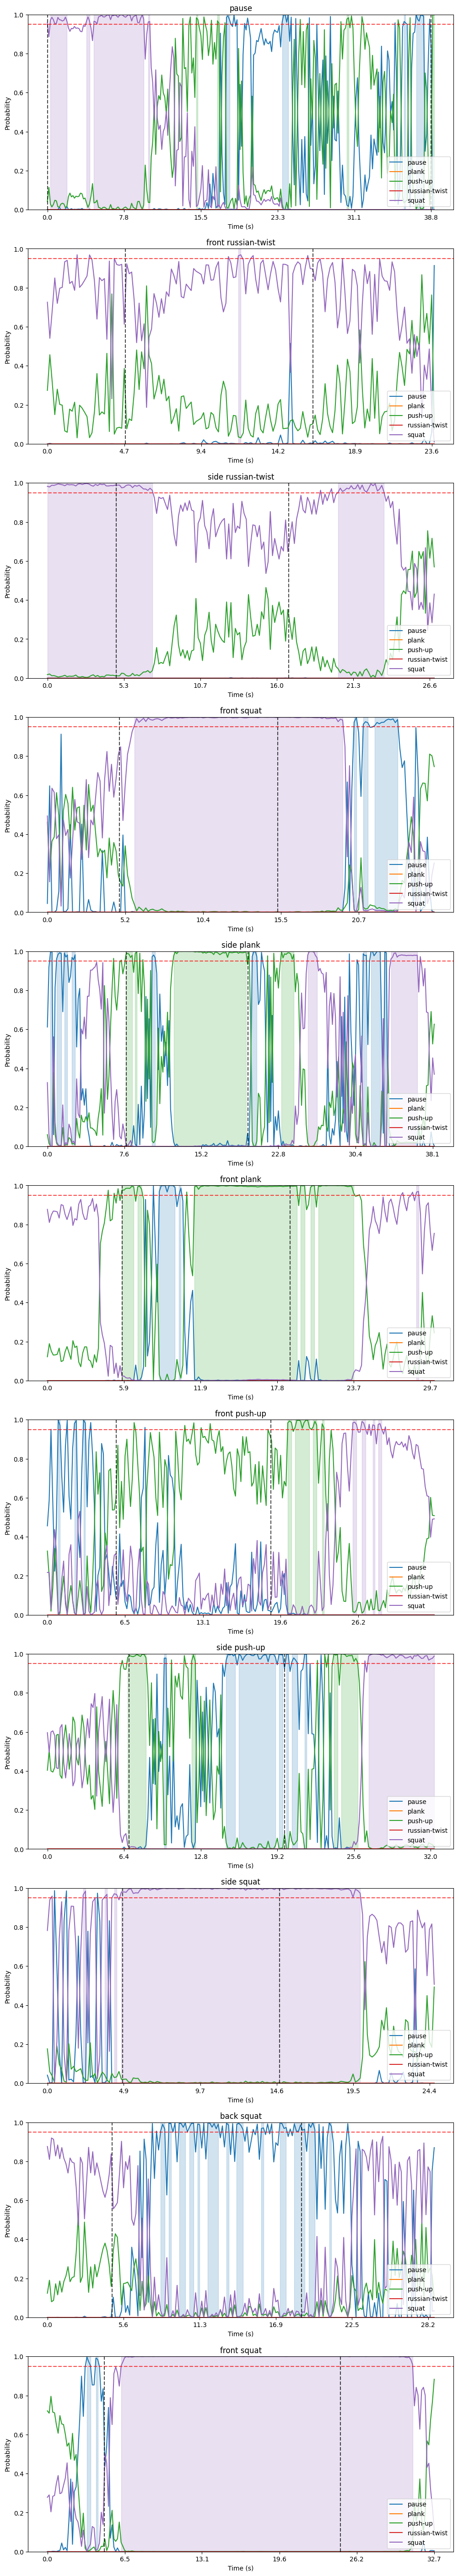

In [67]:
fig, ax = plt.subplots(nrows=11, figsize=(12, 72))

for i in range(11):
    df = pd.read_csv(f"manual_inspection/results/pretrained_{i+1}.csv", sep=";")
    df = df.sort_values(by="timestamp")
    plot_with_prediction(df, ax[i], threshold=video_thresholds[i][0], label=video_thresholds[i][1], confidence_threshold=CONFIDENCE_THRESHOLD)